In [1]:
from __future__ import annotations

import re

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error



def f(x):
    """The function to predict."""
    return x * np.sin(x)


rng = np.random.RandomState(42)
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

In [2]:
class DataGenerator:
    def __init__(self, formula_str: str, x_range: list, n_samples: int, seed: int) -> None:
        self.formula_str = formula_str
        self.x_range = x_range
        self.n_samples = n_samples
        self.seed = seed
        self.rng = np.random.RandomState(seed)

    @property
    def X(self) -> np.array:
        self.rng = np.random.RandomState(42)
        X = np.atleast_2d(self.rng.uniform(*self.x_range, size=self.n_samples)).T
        return X
    
    @property
    def y_raw(self) -> np.array:
        return self._eval_formula().ravel()
    
    @property
    def y(self) -> np.array:
        sigma = 0.5 + self.X.ravel() / 10
        noise = self.rng.lognormal(sigma=sigma) - np.exp(sigma**2 / 2)
        return self.y_raw + noise

    def _eval_formula(self) -> np.array:
        function_map = {
            'sin': "np.sin",
            'cos': "np.cos",
            'exp': "np.exp",
            'log': "np.log",
        }
        # Replace "x" in the formula string with "x_values"
        _formula_str = re.sub(r'\bx\b', '(self.X)', self.formula_str)
        # Replace any function calls in the formula string with the appropriate function object
        _formula_str = re.sub(r'(\w+)\(([^)]*)\)', lambda m: f'{function_map[m.group(1)]}({m.group(2)})', _formula_str)
        # Evaluate the formula using the updated string and return the result
        return eval(_formula_str)
    


In [3]:
gen = DataGenerator(formula_str='x * sin(x)', x_range=[0, 10], n_samples=1000, seed=42)

In [4]:
sigma = 0.5 + X.ravel() / 10
noise = rng.lognormal(sigma=sigma) - np.exp(sigma**2 / 2)
y = expected_y + noise

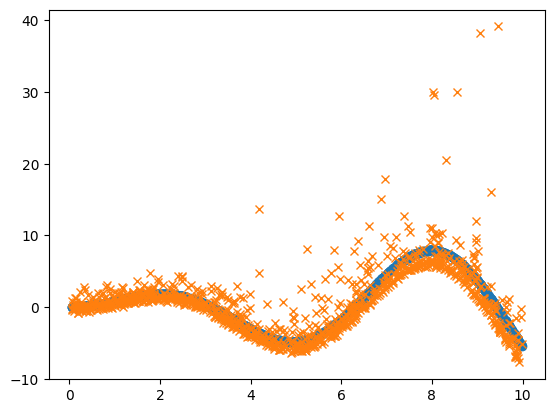

In [5]:
plt.plot(X.ravel(), expected_y, 'o', label='expected')
plt.plot(X.ravel(), y, 'x', label='observed')

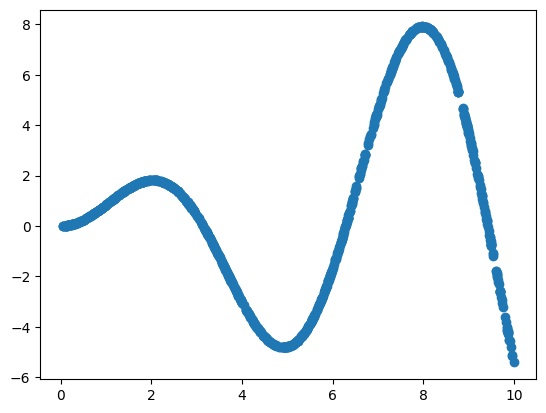

In [6]:
plt.plot(X.ravel(), expected_y, 'o')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
class GradientBoostingCoverage:
    def __init__(self, lower: float, upper: float, **kwargs) -> None:
        self.lower = lower
        self.upper = upper
        self.kwargs = kwargs
        self.models = self._build_models()

    @property
    def coverage(self) -> float:
        return self.upper - self.lower

    def _build_models(self) -> dict[str, GradientBoostingRegressor]:
        models = {}
        for name, alpha in [("lower", self.lower), ("upper", self.upper)]:
            models[f"{name}"] = GradientBoostingRegressor(loss="quantile", alpha=alpha, **self.kwargs)
        return models
    
    def fit(self, X: np.ndarray, y: np.array) -> None:
        for model in self.models.values():
            model.fit(X, y)

    def predict(self, X: np.ndarray) -> tuple[np.array, np.array]:
        lower = self.models["lower"].predict(X)
        upper = self.models["upper"].predict(X)
        return lower, upper

In [9]:
def fit_gradientboosting(X, y, **kwargs) -> GradientBoostingRegressor:
    model = GradientBoostingRegressor(**kwargs)
    model.fit(X, y)
    return model

In [10]:
all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

In [11]:
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)

In [172]:
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T

In [173]:
y_pred = all_models["mse"].predict(xx)
y_lower = all_models["q 0.05"].predict(xx)
y_upper = all_models["q 0.95"].predict(xx)
y_med = all_models["q 0.50"].predict(xx)

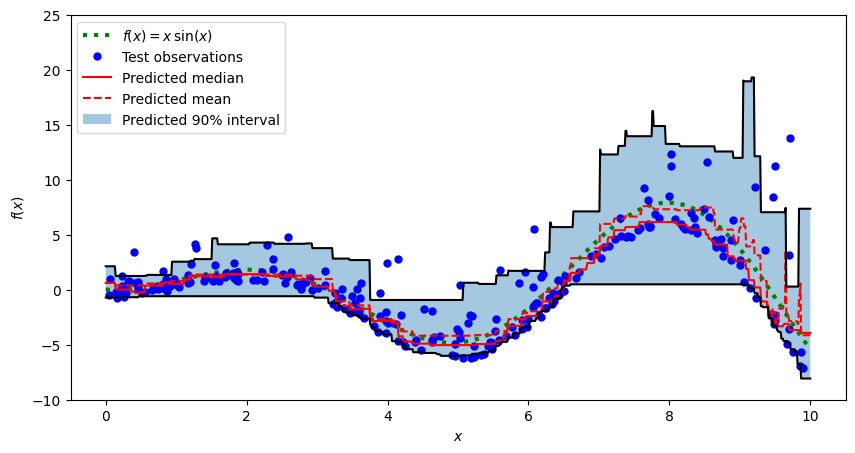

In [174]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_med, "r-", label="Predicted median")
plt.plot(xx, y_pred, "r--", label="Predicted mean")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 25)
plt.legend(loc="upper left")

In [175]:
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

In [178]:
test_coverage = coverage_fraction(
    y_test, 
    all_models["q 0.05"].predict(X_test),
    all_models["q 0.95"].predict(X_test),
)

In [179]:
train_coverage = coverage_fraction(
    y_train, 
    all_models["q 0.05"].predict(X_train),
    all_models["q 0.95"].predict(X_train),
)

In [193]:
import pandas as pd
pd.__version__

'2.0.0'

In [196]:
df_coverage = pd.DataFrame(
    {
        "Split": ["Train", "Test"],
        "Coverage": [f"{train_coverage*100:.0f}", f"{test_coverage*100:.0f}"],
        "Expected Coverage": [f"{0.9*100:.0f}", f"{0.9*100:.0f}"],
    }
)
df_coverage

,Split,Coverage,Expected Coverage
0,Train,90,90
1,Test,85,90


In [192]:
import plotly.express as px

fig = px.bar(x=["Train", "Test"], y=[train_coverage, test_coverage])
fig.add_shape(
    type='line', line=dict(dash='dash', color='red'),
    x0="Train", x1="Test", y0=0.90, y1=.90, name="Expected"
)
fig.update_layout(
    xaxis_title="Split",
    yaxis_title="Coverage",
    title="Coverage Comparison for Train and Test Split"
)

In [33]:
# Using plotly to plot an interval
fig = go.Figure()
fig.add_trace(go.Scatter(x=xx.ravel(), y=y_upper, fill=None, mode="lines", line_color="rgba(255,255,0,0)", name=""))
fig.add_trace(go.Scatter(x=xx.ravel(), y=y_lower, fill="tonexty", mode="lines", line_color="rgba(255,255,0,0)", name="Predicted 90% Interval"))
fig.add_trace(go.Scatter(x=xx.ravel(), y=y_med, mode="lines", line_color="red", name='Predicted Median'))
fig.add_trace(go.Scatter(x=X_test.ravel(), y=y_test, mode="markers", marker_color="blue", name="Test Observations"))
fig.update_layout(
    xaxis_title="x",
    yaxis_title="f(x)",
    yaxis_range=[-10, 25],
    legend_title="Legend",
    font=dict(
        family="Courier New, monospace",
        size=13,
        color="RebeccaPurple"
    )
)
fig.show()

# Testing my Implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

import utils

In [2]:
formula_str = "x * sin(x)" 
n_samples =  1000
lower = 0.05
upper = 0.95
learning_rate = 0.05 
n_estimators = 200
max_depth = 3

In [3]:
x_range = [0, 10]
gen = utils.DataGenerator(formula_str, x_range=x_range, n_samples=n_samples, seed=42)
X = gen.X
y_raw = gen.y_raw

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Model Parameters
model_kwargs = {
    "learning_rate": learning_rate,
    "n_estimators": n_estimators,
    "max_depth": max_depth,
}

In [4]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)


rng = np.random.RandomState(42)
_X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

In [8]:
np.tan(2)

-2.185039863261519

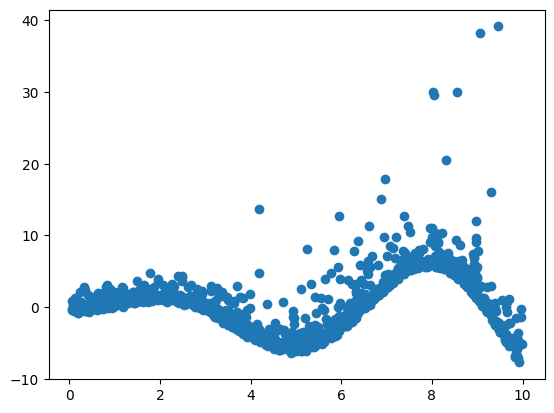

In [5]:
plt.plot(gen.X.ravel(), gen.y.ravel(), 'o')

In [239]:
gen.formula_str

'x*sin(x)'